No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


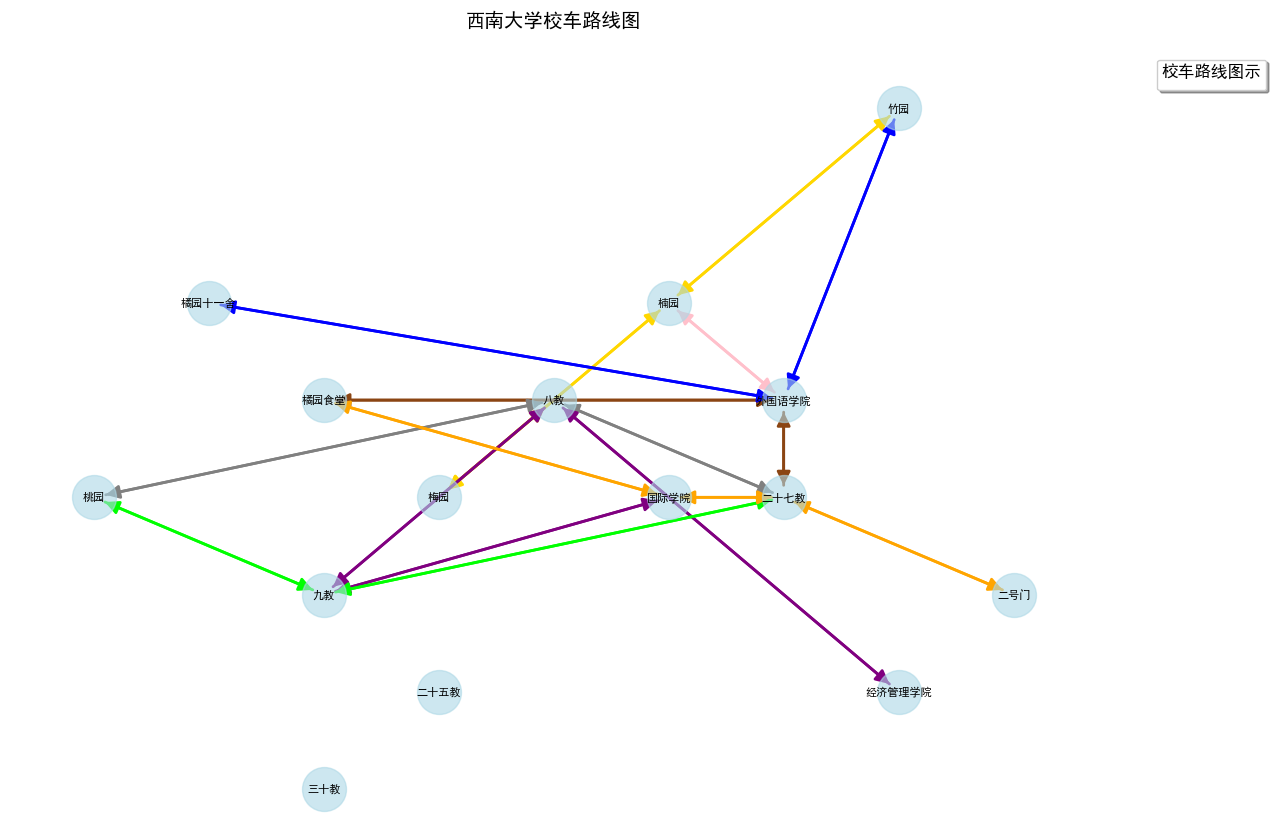

早高峰最短时间: 4.1 min
下课高峰最短时间: 4.1 min


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# ===================== 数据结构定义 =====================

class Bus:
    def __init__(self, bus_id, route_id, capacity, bus_type):
        self.bus_id = bus_id
        self.route_id = route_id
        self.capacity = capacity
        self.bus_type = bus_type  # 普通/高峰/支线
        self.location = None
        self.passengers = 0

class Station:
    def __init__(self, name, demand_dict):
        self.name = name
        self.demand_dict = demand_dict  # {目标站点: 人数}

# ===================== 数据初始化 =====================

def load_station_data():
    stations = []
    # 早高峰时期的需求(7:30)
    morning_demands = {
        "竹园": {
            "国际学院": 120, "八教": 120, "九教": 120, 
            "二十七教": 120, "外国语学院": 120
        },
        "楠园": {
            "国际学院": 120, "八教": 120, "九教": 120,
            "二十七教": 120, "经济管理学院": 120
        },
        "梅园": {"八教": 200, "九教": 200},
        "八教": {"九教": 250, "二十七教": 250},
        "橘园十一舍": {"八教": 100, "外国语学院": 100},
        "橘园食堂": {"八教": 133, "二十七教": 133, "外国语学院": 134},
        "桃园": {"八教": 100, "二十七教": 100, "外国语学院": 100}
    }
    
    # 下课时期的需求(9:45)
    afternoon_demands = {
        "国际学院": {"竹园": 100},
        "二十七教": {
            "竹园": 70, "橘园": 70, "楠园": 70,
            "桃园": 70, "二号门": 70
        },
        "九教": {"八教": 57, "梅园": 57, "楠园": 56},
        "八教": {"楠园": 175, "竹园": 175},
        "外国语学院": {
            "楠园": 38, "竹园": 38, "桃园": 37, "橘园": 37
        },
        "经济管理学院": {"楠园": 80},
        "三十教": {"楠园": 50, "二十五教": 50}
    }
    
    # 创建所有站点的对象，包括目标站点
    all_stations = set()
    
    # 收集所有站点（包括起点和终点）
    for source, demands in morning_demands.items():
        all_stations.add(source)
        all_stations.update(demands.keys())
        
    for source, demands in afternoon_demands.items():
        all_stations.add(source)
        all_stations.update(demands.keys())
    
    # 创建站点对象
    stations = []
    for station_name in all_stations:
        demands = {}
        if station_name in morning_demands:
            demands = morning_demands[station_name]
        stations.append(Station(station_name, demands))
    
    return stations, morning_demands, afternoon_demands

def load_bus_data():
    buses = []
    # 根据题目给定的车辆数据创建校车对象
    bus_configs = [
        (1, 3, 13, "普通"),  # (路线号, 数量, 容量, 类型)
        (2, 2, 13, "普通"),
        (3, 5, 13, "普通"),
        (4, 8, 26, "普通"),
        (5, 6, 13, "普通"),
        (6, 5, 26, "普通"),
        (7, 6, 26, "普通"),
        (8, 4, 13, "普通"),
        (9, 2, 13, "支线"),
        (10, 4, 13, "高峰车1"),
        (11, 6, 26, "高峰车2")
    ]
    
    bus_id = 1
    for route_id, count, capacity, bus_type in bus_configs:
        for _ in range(count):
            buses.append(Bus(bus_id, route_id, capacity, bus_type))
            bus_id += 1
    
    return buses

def load_routes():
    G = nx.DiGraph()
    
    # 添加站点
    stations = [
        "竹园", "楠园", "梅园", "八教", "九教", "二十七教", 
        "外国语学院", "橘园十一舍", "橘园食堂", "桃园", 
        "经济管理学院", "二号门", "二十五教", "三十教", "国际学院"
    ]
    
    # 先添加所有节点
    G.add_nodes_from(stations)
    
    # 添加路线（根据地图添加边）
    routes = [
        # 1号线(黄色)
        ("竹园", "楠园", {"route": 1, "distance": 0.5}),
        ("楠园", "梅园", {"route": 1, "distance": 0.4}),
        ("梅园", "八教", {"route": 1, "distance": 0.3}),
        
        # 2号线(粉色)
        ("楠园", "外国语学院", {"route": 2, "distance": 0.4}),
        ("外国语学院", "二十七教", {"route": 2, "distance": 0.3}),
        
        # 3号线(褐色)
        ("橘园食堂", "外国语学院", {"route": 3, "distance": 0.5}),
        ("外国语学院", "二十七教", {"route": 3, "distance": 0.4}),
        
        # 4号线(灰色)
        ("桃园", "八教", {"route": 4, "distance": 0.6}),
        ("八教", "二十七教", {"route": 4, "distance": 0.5}),
        
        # 5号线(紫色)
        ("国际学院", "九教", {"route": 5, "distance": 0.4}),
        ("九教", "八教", {"route": 5, "distance": 0.4}),
        ("八教", "经济管理学院", {"route": 5, "distance": 0.5}),
        
        # 6号线(绿色)
        ("桃园", "九教", {"route": 6, "distance": 0.5}),
        ("九教", "二十七教", {"route": 6, "distance": 0.6}),
        
        # 7号线(橙色)
        ("橘园食堂", "国际学院", {"route": 7, "distance": 0.5}),
        ("国际学院", "二十七教", {"route": 7, "distance": 0.6}),
        ("二十七教", "二号门", {"route": 7, "distance": 0.4}),
        
        # 8号线(蓝色)
        ("橘园十一舍", "外国语学院", {"route": 8, "distance": 0.4}),
        ("外国语学院", "竹园", {"route": 8, "distance": 0.7}),
        
        # 添加额外的连接路径
        ("八教", "九教", {"route": 5, "distance": 0.4}),
        ("八教", "二十七教", {"route": 4, "distance": 0.5})
    ]
    
    # 添加边和反向边
    for start, end, attr in routes:
        G.add_edge(start, end, **attr)
        G.add_edge(end, start, **attr)
    
    return G

# ===================== 调度与仿真核心 =====================

def assign_buses_to_routes(buses, stations, G, demand_type="morning"):
    """车辆调度分配算法
    使用贪心算法,根据站点需求量分配校车
    """
    # 计算每条路线的总需求量
    route_demands = {}
    for station in stations:
        for dest, demand in station.demand_dict.items():
            try:
                path = nx.shortest_path(G, station.name, dest, weight='distance')
                for i in range(len(path)-1):
                    edge = G[path[i]][path[i+1]]
                    route = edge['route']
                    route_demands[route] = route_demands.get(route, 0) + demand
            except nx.NodeNotFound:
                print(f"警告: 找不到从 {station.name} 到 {dest} 的路径")
                continue

    # 给高峰车分配需求量最大的路线
    peak_buses = [bus for bus in buses if "高峰" in bus.bus_type]
    normal_buses = [bus for bus in buses if "高峰" not in bus.bus_type]
    
    sorted_routes = sorted(route_demands.items(), key=lambda x: x[1], reverse=True)
    
    # 分配高峰车
    for bus in peak_buses:
        if sorted_routes:
            bus.route_id = sorted_routes[0][0]
            sorted_routes.pop(0)
            
    # 分配普通车和支线车
    for bus in normal_buses:
        if bus.bus_type != "支线":  # 保持原有路线
            continue
        if sorted_routes:
            bus.route_id = sorted_routes[0][0]
            sorted_routes.pop(0)

    return buses

def simulate_transport(buses, stations, G, speed=15, load_time=3):
    """校车运输过程仿真"""
    total_time = 0
    
    # 初始化所有站点的乘客信息
    remaining_passengers = {}
    for station in stations:
        remaining_passengers[station.name] = station.demand_dict.copy()
    
    while any(bool(demands) for demands in remaining_passengers.values()):
        # 每辆车一轮运行
        for bus in buses:
            # 获取当前路线的站点
            route_edges = [(u, v) for u, v, d in G.edges(data=True) if d['route'] == bus.route_id]
            if not route_edges:
                continue
                
            current_passengers = 0
            bus.location = route_edges[0][0]
            
            # 沿路线运行
            for start, end in route_edges:
                if start not in remaining_passengers:
                    remaining_passengers[start] = {}
                if end not in remaining_passengers:
                    remaining_passengers[end] = {}
                    
                # 计算行驶时间
                distance = G[start][end]['distance']
                travel_time = (distance / speed) * 60  # 转换为分钟
                
                # 上下车时间
                if remaining_passengers[start]:
                    boarding_time = min(
                        bus.capacity - current_passengers,  # 剩余容量
                        sum(remaining_passengers[start].values())  # 等待人数
                    ) * load_time / 60  # 转换为分钟
                    travel_time += boarding_time
                    
                    # 更新剩余乘客
                    for dest in list(remaining_passengers[start].keys()):
                        if current_passengers < bus.capacity:
                            passengers_to_board = min(
                                remaining_passengers[start][dest],
                                bus.capacity - current_passengers
                            )
                            current_passengers += passengers_to_board
                            remaining_passengers[start][dest] -= passengers_to_board
                            if remaining_passengers[start][dest] == 0:
                                del remaining_passengers[start][dest]
                
                total_time = max(total_time, travel_time)
                bus.location = end
    
    return total_time

# ===================== 不确定性分析 =====================

def uncertainty_analysis(buses, stations, G):
    """不确定性分析"""
    results = []
    variations = [
        (1.15, 1.05), (1.15, 0.95),  # 人数增加15%
        (0.85, 1.05), (0.85, 0.95)   # 人数减少15%
    ]
    
    for demand_factor, speed_factor in variations:
        # 修改需求
        for station in stations:
            for dest in station.demand_dict:
                station.demand_dict[dest] = int(station.demand_dict[dest] * demand_factor)
        
        # 仿真运行
        time = simulate_transport(buses, stations, G, speed=15*speed_factor)
        results.append((demand_factor, speed_factor, time))
        
        # 恢复原始需求
        for station in stations:
            for dest in station.demand_dict:
                station.demand_dict[dest] = int(station.demand_dict[dest] / demand_factor)
    
    return results

# ===================== 可视化与结果输出 =====================

def visualize_routes(G):
    """可视化路线图"""
    plt.figure(figsize=(15, 10))
    
    # 定义路线颜色和名称，与原图保持一致
    route_colors = {
        1: {'color': '#FFD700', 'name': '1号线(黄色)'},  # 黄色
        2: {'color': '#FFC0CB', 'name': '2号线(粉色)'},  # 粉色
        3: {'color': '#8B4513', 'name': '3号线(褐色)'},  # 褐色
        4: {'color': '#808080', 'name': '4号线(灰色)'},  # 灰色
        5: {'color': '#800080', 'name': '5号线(紫色)'},  # 紫色
        6: {'color': '#00FF00', 'name': '6号线(绿色)'},  # 绿色
        7: {'color': '#FFA500', 'name': '7号线(橙色)'},  # 橙色
        8: {'color': '#0000FF', 'name': '8号线(蓝色)'}   # 蓝色
    }
    
    # 手动设置节点位置，根据实际地图布局
    pos = {
        "竹园": (8, 8), 
        "楠园": (6, 6),
        "梅园": (4, 4),
        "八教": (5, 5),
        "九教": (3, 3),
        "二十七教": (7, 4),
        "外国语学院": (7, 5),
        "橘园十一舍": (2, 6),
        "橘园食堂": (3, 5),
        "桃园": (1, 4),
        "经济管理学院": (8, 2),
        "国际学院": (6, 4),
        "二号门": (9, 3),
        "二十五教": (4, 2),
        "三十教": (3, 1)
    }
    
    # 绘制不同路线
    for route_id, route_info in route_colors.items():
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['route'] == route_id]
        if edges:  # 只在有边时才绘制
            nx.draw_networkx_edges(G, pos, edgelist=edges, 
                                 edge_color=route_info['color'],
                                 label=route_info['name'], 
                                 width=2,
                                 arrows=True,
                                 arrowsize=20)
    
    # 绘制节点和标签
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1000, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='SimHei')
    
    # 添加图例，并调整位置和大小
    plt.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              title='校车路线图示',
              title_fontsize=12,
              fontsize=8,
              frameon=True,
              fancybox=True,
              shadow=True)
    
    # 添加标题
    plt.title("西南大学校车路线图", fontsize=14, fontfamily='SimHei', pad=20)
    
    # 调整布局
    plt.axis('off')
    plt.subplots_adjust(right=0.85)  # 为图例留出空间
    
    # 确保中文正常显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.show()

def main():
    stations, morning_demands, afternoon_demands = load_station_data()
    buses = load_bus_data()
    G = load_routes()
    
    # 1. 早高峰调度
    assign_buses_to_routes(buses, stations, G, demand_type="morning")
    time1 = simulate_transport(buses, stations, G)
    
    # 2. 下课高峰调度
    assign_buses_to_routes(buses, stations, G, demand_type="afternoon")
    time2 = simulate_transport(buses, stations, G)
    
    # 3. 车辆自由调配优化
    # TODO: 实现车辆自由调配的优化算法
    # time3 = ...
    
    # 4. 不确定性分析
    uncertainty_analysis(buses, stations, G)
    
    # 可视化
    visualize_routes(G)
    print(f"早高峰最短时间: {time1} min")
    print(f"下课高峰最短时间: {time2} min")

if __name__ == "__main__":
    main()

请输入地铁线路（格式示例：1号线：A站，B站，C站），输入空行结束：


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



线路信息表：
Empty DataFrame
Columns: [线路名称, 站点列表]
Index: []


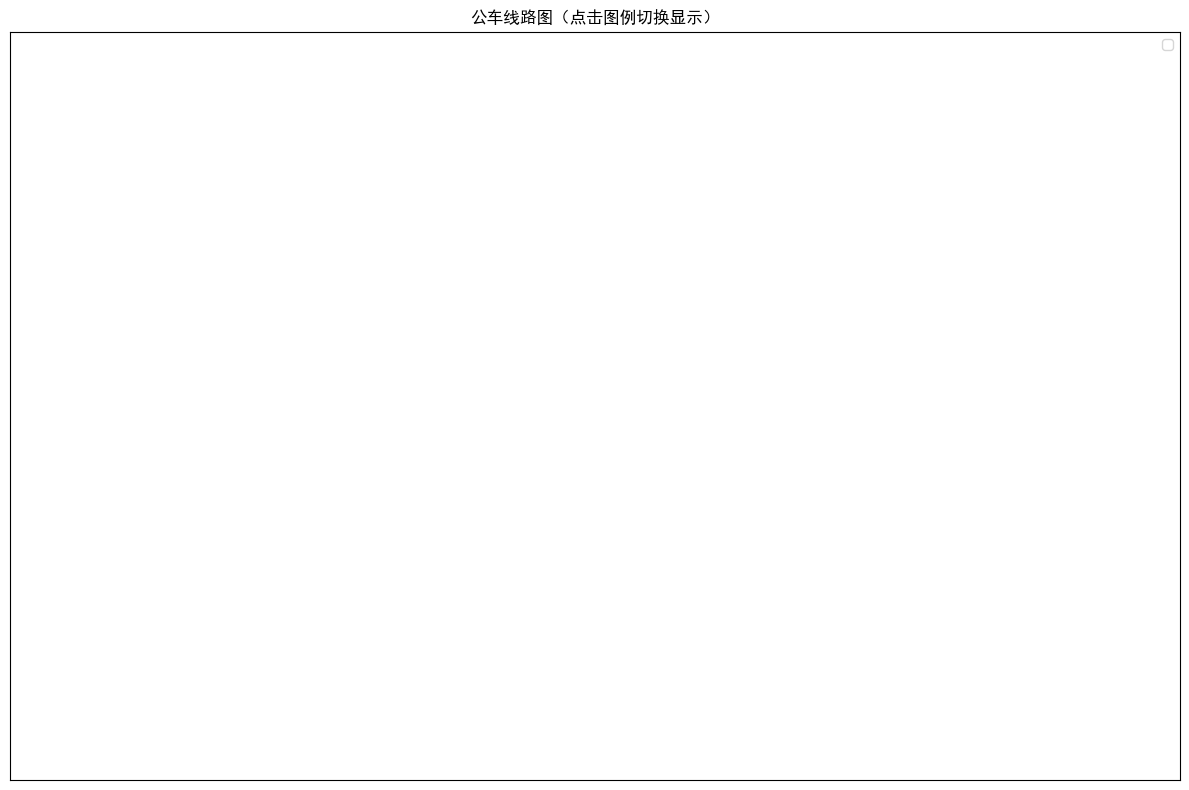

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import rcParams
from collections import defaultdict

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

def on_legend_click(event):
    """图例点击事件处理"""
    legend_line = event.artist
    line_name = legend_line.get_label()
    if line_name in lined:
        visibility = not lined[line_name][0].get_visible()
        for line in lined[line_name]:
            line.set_visible(visibility)
        plt.draw()

# 用户输入处理
def get_user_input():
    print("请输入地铁线路（格式示例：1号线：A站，B站，C站），输入空行结束：")
    lines = []
    while True:
        s = input().strip()
        if not s:
            break
        if ':' not in s:
            print(f"格式错误：'{s}' 请使用中文冒号！")
            continue
        name, stations = s.split(':', 1)
        stations = [s.strip() for s in stations.split(',')]
        lines.append((name.strip(), stations))
    return lines

# 主逻辑
if __name__ == "__main__":
    # 获取输入
    lines = get_user_input()
    
    # 构建网络图
    G = nx.Graph()
    edge_to_lines = defaultdict(list)
    for idx, (name, stations) in enumerate(lines):
        for i in range(len(stations)-1):
            u, v = stations[i], stations[i+1]
            edge = tuple(sorted([u, v]))
            edge_to_lines[edge].append(name)
            G.add_edge(u, v)
    
    # 自动布局
    pos = nx.kamada_kawai_layout(G, dim=2)
    
    # 创建图表
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    
    # 颜色分配
    color_map = plt.cm.tab10.colors[:len(lines)]
    
    # 曲线绘制核心代码
    lined = {}
    for idx, (name, stations) in enumerate(lines):
        color = color_map[idx]
        line_segments = []
        
        for i in range(len(stations)-1):
            u, v = stations[i], stations[i+1]
            edge = tuple(sorted([u, v]))
            
            # 获取线路信息
            total = len(edge_to_lines[edge])
            position = edge_to_lines[edge].index(name)
            
            # 动态曲率控制
            start = pos[u]
            end = pos[v]
            dx = end[0] - start[0]
            dy = end[1] - start[1]
            edge_length = np.hypot(dx, dy)
            curvature = 0.15 * edge_length  # 优化后的曲率系数
            
            # 生成贝塞尔曲线
            if position == 0:
                # 主线路保持直线
                vertices = [start, end]
                codes = [Path.MOVETO, Path.LINETO]
            else:
                # 智能弯曲方向
                direction = -1 if position % 2 else 1
                angle = np.arctan2(dy, dx)
                
                # 控制点计算
                ctrl1 = [
                    start[0] + curvature * np.cos(angle - np.pi/2 * direction),
                    start[1] + curvature * np.sin(angle - np.pi/2 * direction)
                ]
                ctrl2 = [
                    end[0] - curvature * np.cos(angle + np.pi/2 * direction),
                    end[1] - curvature * np.sin(angle + np.pi/2 * direction)
                ]
                
                vertices = [start, ctrl1, ctrl2, end]
                codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
            
            # 创建路径
            path = Path(vertices, codes)
            patch = patches.PathPatch(
                path,
                lw=2,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            line = ax.add_patch(patch)
            line_segments.append(line)
        
        lined[name] = line_segments
        # 添加图例代理
        ax.plot([], [], color=color, label=name, lw=2)
    
    # 交互图例
    legend = ax.legend(loc='upper right')
    for legend_line in legend.get_lines():
        legend_line.set_picker(5)
    plt.connect('pick_event', on_legend_click)
    
    # 显示表格
    df = pd.DataFrame([(name, '→'.join(stations)) for name, stations in lines],
                     columns=['线路名称', '站点列表'])
    print("\n线路信息表：")
    print(df.to_string(index=False))
    
    plt.title("公车线路图（点击图例切换显示）")
    plt.tight_layout()
    plt.show()
    